Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 1
    - coreLimit: "2000m"
    - instances: 2
    - memory: "1500m"

30/05/2025
18h25
19h20

Commit 4611fbdb747d1d453882a8ddc5204f4af087a047

In [1]:
import sys
from pathlib import Path

import pandas as pd

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from charts import (
    latency_box_plot,
    latency_distribution_plot,
    latency_line_plot,
)
from functions import calculate_latencies
from utils import fix_timestamps_timezone

experiment_name = "experiment05"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-05-30-20_36_38-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-05-30-20_22_56-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [2]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [3]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [4]:
start_time = pd.Timestamp("2025-05-30 18:20:00", tz="UTC")
end_time = pd.Timestamp("2025-05-30 19:20:00", tz="UTC")

df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


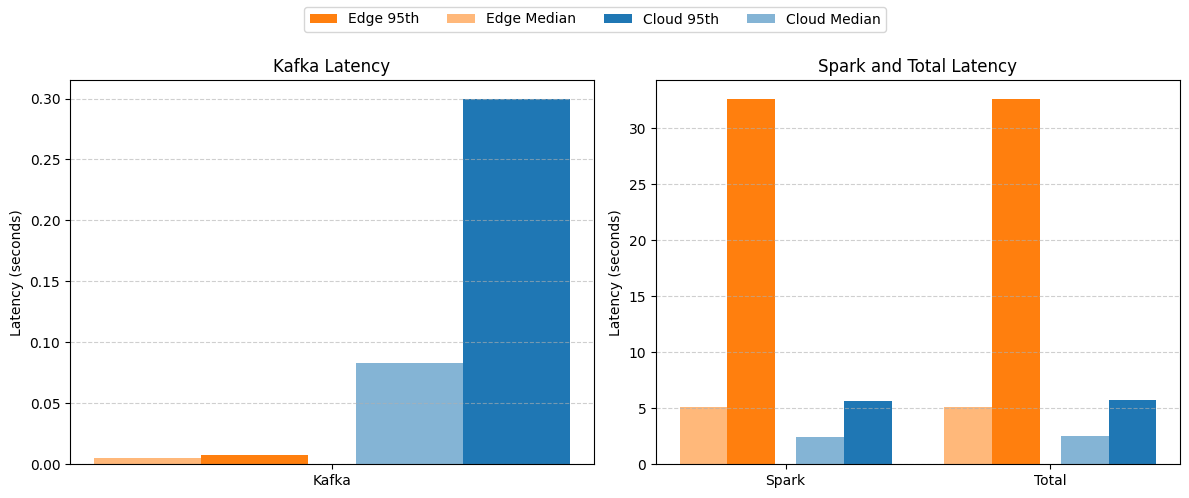

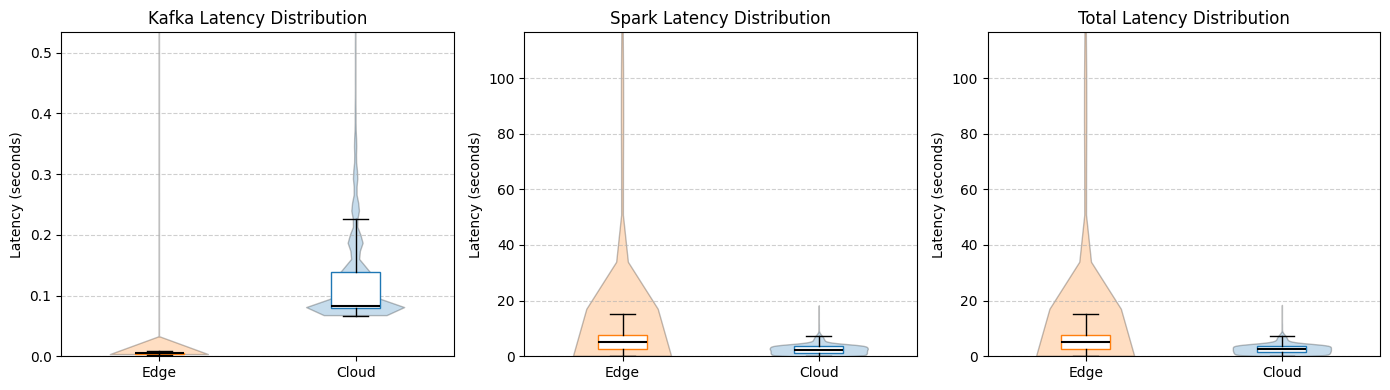

In [5]:
from charts import latency_summary_bar_chart, latency_violin_box_overlay

# Ensure a common schema like: ['environment', 'stage', 'latency_s']
df_edge["environment"] = "Edge"
df_cloud["environment"] = "Cloud"
df = pd.concat([df_edge, df_cloud], ignore_index=True)

# Now plot
latency_summary_bar_chart(df, save_path="./latency_summary.png")
latency_violin_box_overlay(df, save_path="./latency_violin.png")

In [8]:
import numpy as np
from charts import _prepare_latency_long


def summarize_latencies_ms(df: pd.DataFrame) -> pd.DataFrame:
    long_df = _prepare_latency_long(df)
    summ = (
        long_df.groupby(["stage", "environment"])["latency_s"]
        .agg(
            median=lambda s: np.nanmedian(s),
            iqr=lambda s: np.nanpercentile(s, 75) - np.nanpercentile(s, 25),
            p95=lambda s: np.nanpercentile(s, 95),
        )
        .mul(1000)  # seconds -> milliseconds
        .round(1)   # 0.1 ms resolution is sufficient for reporting
        .reset_index()
        .pivot(index=["stage"], columns="environment")
        .sort_index()
    )
    # Make a flat column index like 'median.Edge (ms)'
    summ.columns = [f"{stat}.{env} (ms)" for stat, env in summ.columns]
    return summ

stats_ms = summarize_latencies_ms(df)
display(stats_ms)

# Convenience accessors for your paragraph (edit rounding as you prefer)
def val(stage, stat, env):
    return float(stats_ms.loc[stage, f"{stat}.{env} (ms)"])

k_edge_med   = val("Kafka", "median", "Edge")
k_edge_p95   = val("Kafka", "p95",    "Edge")
k_cloud_med  = val("Kafka", "median", "Cloud")
k_cloud_p95  = val("Kafka", "p95",    "Cloud")

s_edge_med   = val("Spark", "median", "Edge")
s_cloud_med  = val("Spark", "median", "Cloud")
s_cloud_p95  = val("Spark", "p95",    "Cloud")

t_edge_med   = val("Total", "median", "Edge")
t_cloud_med  = val("Total", "median", "Cloud")
t_cloud_p95  = val("Total", "p95",    "Cloud")

print(
    f"Kafka — Edge median: {k_edge_med:.1f} ms; Edge P95: {k_edge_p95:.1f} ms; "
    f"Cloud median: {k_cloud_med:.1f} ms; Cloud P95: {k_cloud_p95:.1f} ms."
)
print(
    f"Spark — Edge median: {s_edge_med:.1f} ms; Cloud median: {s_cloud_med:.1f} ms; "
    f"Cloud P95: {s_cloud_p95:.1f} ms."
)
print(
    f"Total — Edge median: {t_edge_med:.1f} ms; Cloud median: {t_cloud_med:.1f} ms; "
    f"Cloud P95: {t_cloud_p95:.1f} ms."
)

# Optional: a ready-to-paste sentence that mirrors your paragraph but with exact numbers
print(
    "\nSentence for the paper:\n"
    f"Edge ingestion remained below approximately {k_edge_med:.0f} ms for most of the distribution, "
    f"with a 95th percentile of {k_edge_p95:.0f} ms, while the cloud presented a wider spread with a "
    f"median of {k_cloud_med:.0f} ms and tails reaching {k_cloud_p95:.0f} ms. "
    f"Persistence latency dominated the end-to-end budget, with edge median values of {s_edge_med:.0f} ms "
    f"and cloud of {s_cloud_med:.0f} ms, and a cloud 95th percentile of {s_cloud_p95:.0f} ms."
)

/tmp/ipykernel_18683/723451813.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


,median.Cloud (ms),median.Edge (ms),iqr.Cloud (ms),iqr.Edge (ms),p95.Cloud (ms),p95.Edge (ms)
stage,,,,,,
Kafka,83.1,4.9,58.6,2.0,299.9,8.0
Spark,2428.0,5101.0,2392.0,5115.0,5649.0,32637.0
Total,2559.1,5107.3,2393.5,5114.4,5768.6,32642.7


Kafka — Edge median: 4.9 ms; Edge P95: 8.0 ms; Cloud median: 83.1 ms; Cloud P95: 299.9 ms.
Spark — Edge median: 5101.0 ms; Cloud median: 2428.0 ms; Cloud P95: 5649.0 ms.
Total — Edge median: 5107.3 ms; Cloud median: 2559.1 ms; Cloud P95: 5768.6 ms.

Sentence for the paper:
Edge ingestion remained below approximately 5 ms for most of the distribution, with a 95th percentile of 8 ms, while the cloud presented a wider spread with a median of 83 ms and tails reaching 300 ms. Persistence latency dominated the end-to-end budget, with edge median values of 5101 ms and cloud of 2428 ms, and a cloud 95th percentile of 5649 ms.


/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


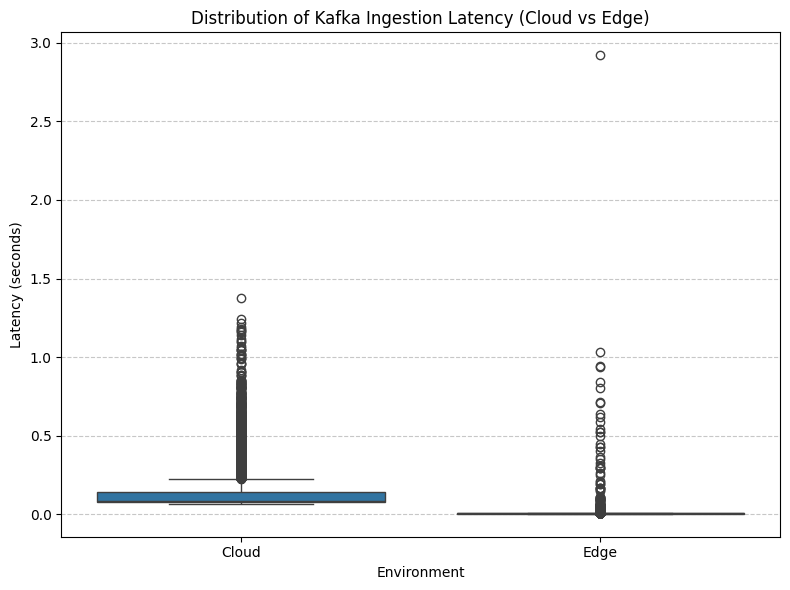

In [5]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency", save_path="./latency-kafka-boxplot.png")

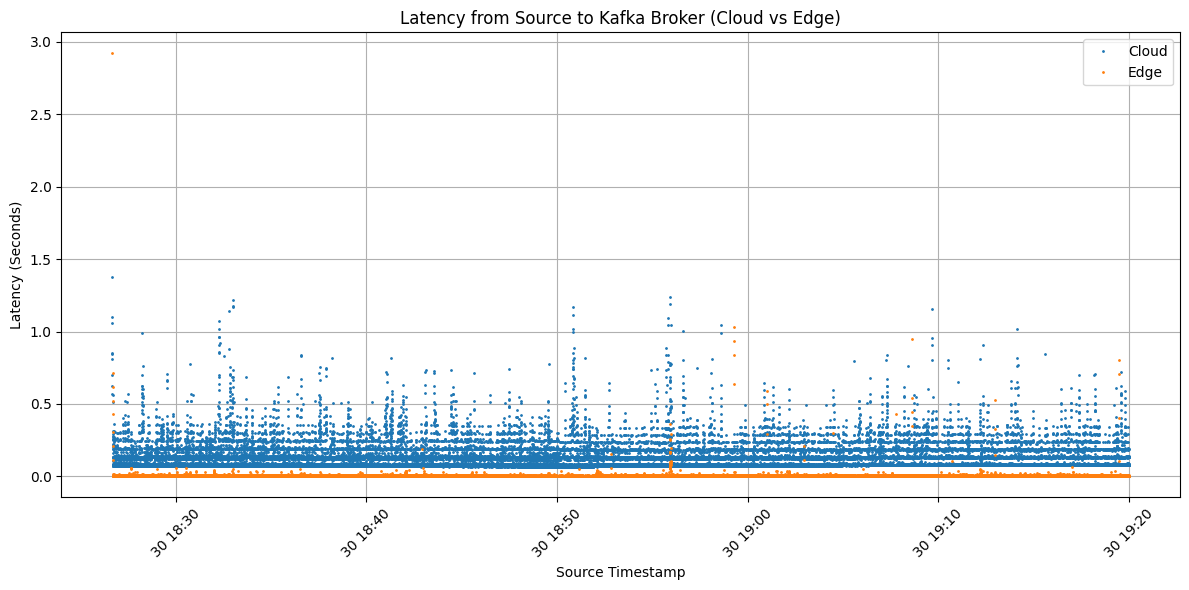

In [6]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency", save_path="./latency-kafka-scatterplot.png")

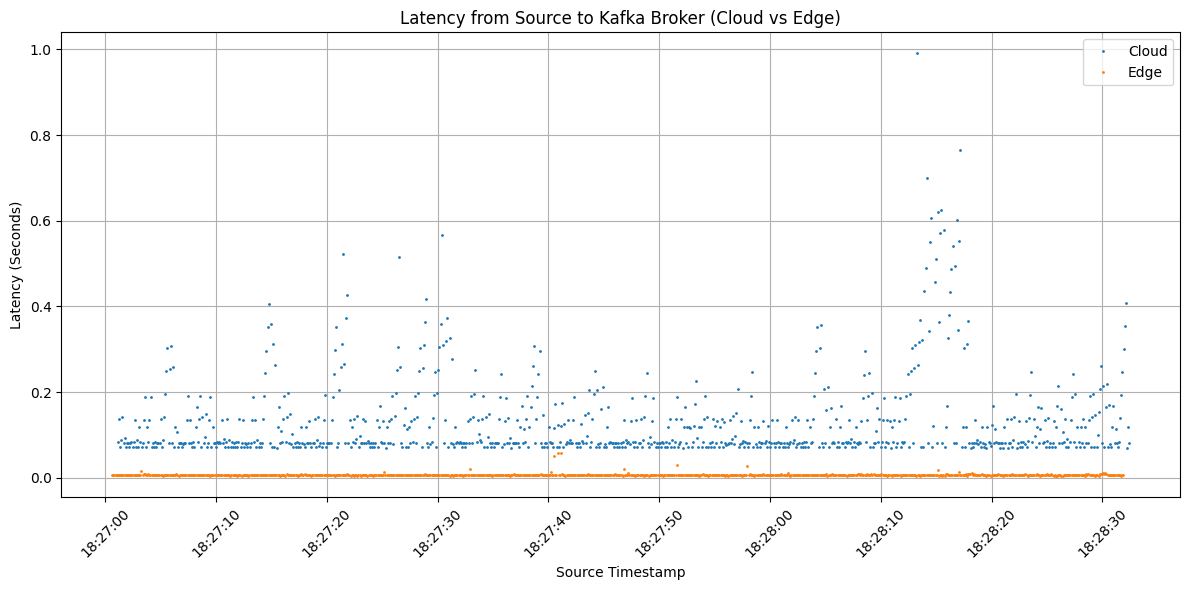

In [7]:
latency_line_plot(df_cloud_filtered[200:1100], df_edge_filtered[170:1070], x="source_timestamp", y="source_kafka_latency")

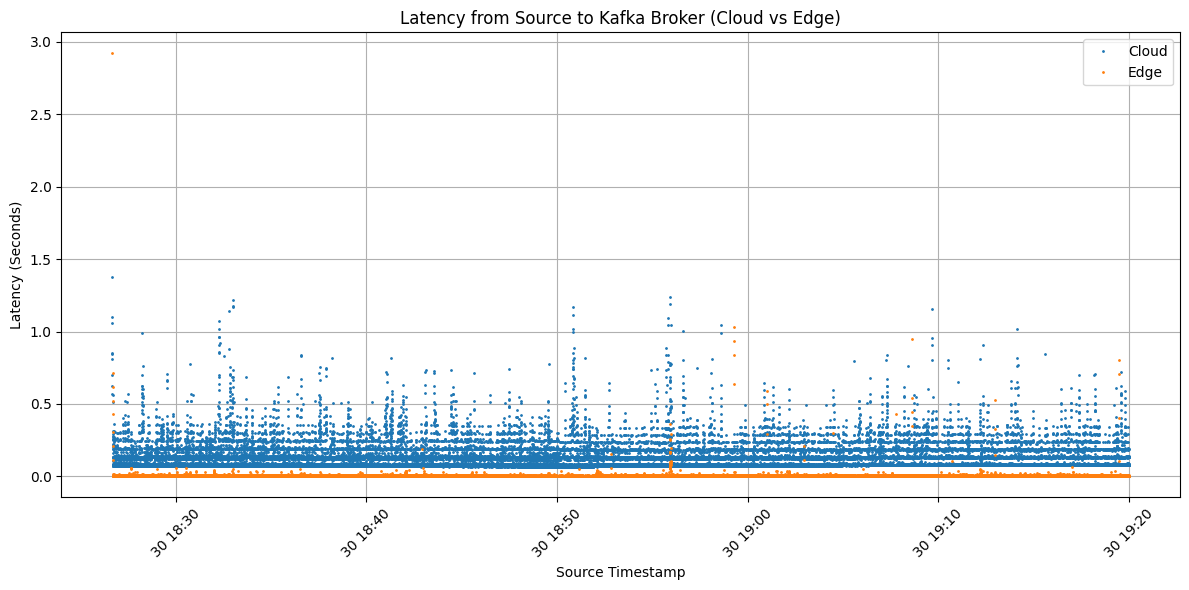

In [8]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                 mean    median       std
Environment                              
Cloud        0.131362  0.083083  0.092661
Edge         0.006086  0.004870  0.023942


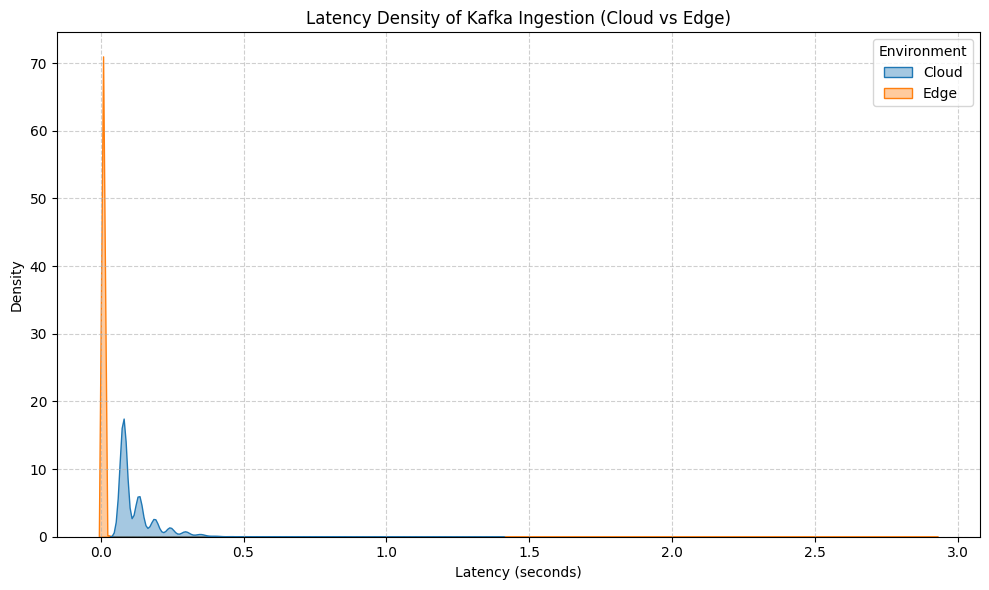

In [9]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency", save_path="./latency-kafka-density.png")

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


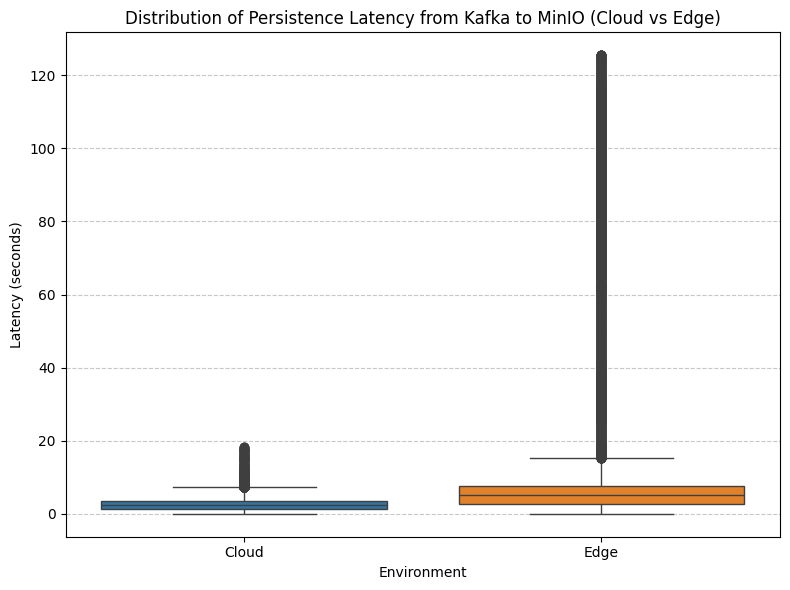

In [10]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Distribution of Persistence Latency from Kafka to MinIO (Cloud vs Edge)", save_path="./latency-spark-boxplot.png")

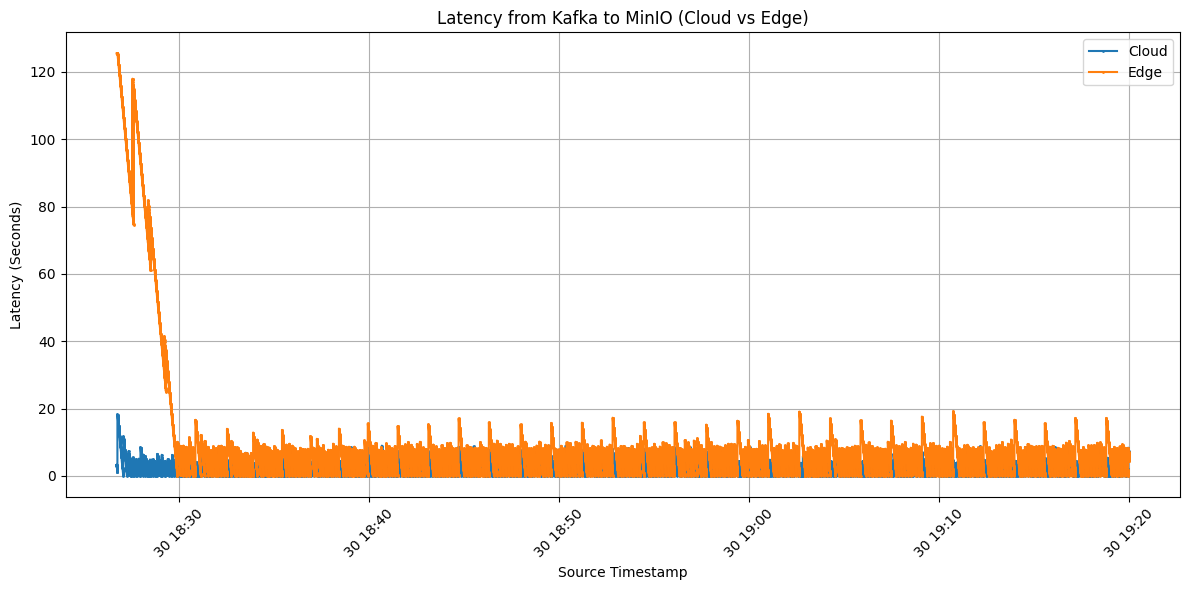

In [11]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency from Kafka to MinIO (Cloud vs Edge)', linestyle="solid", save_path="./latency-spark-scatterplot.png")

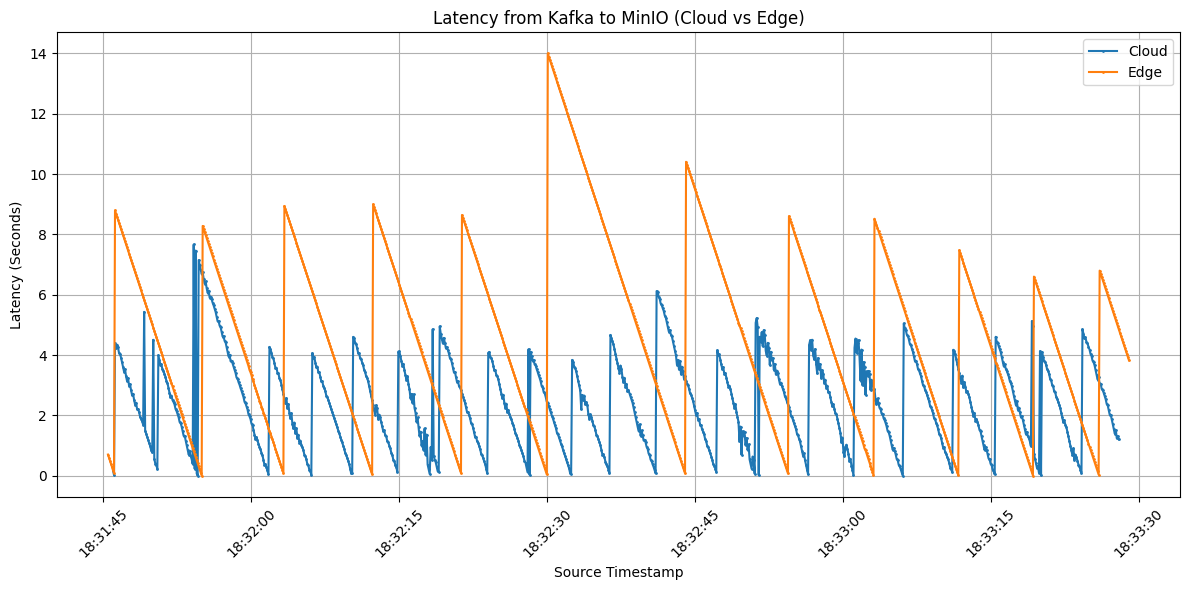

In [12]:
latency_line_plot(df_cloud_filtered[3000:4000], df_edge_filtered[2970:3985], x='source_timestamp', y='kafka_landing_latency', title='Latency from Kafka to MinIO (Cloud vs Edge)', linestyle="solid")

📊 Statistics:
                 mean  median        std
Environment                             
Cloud        2.584331   2.427   1.775343
Edge         8.897339   5.099  17.553246


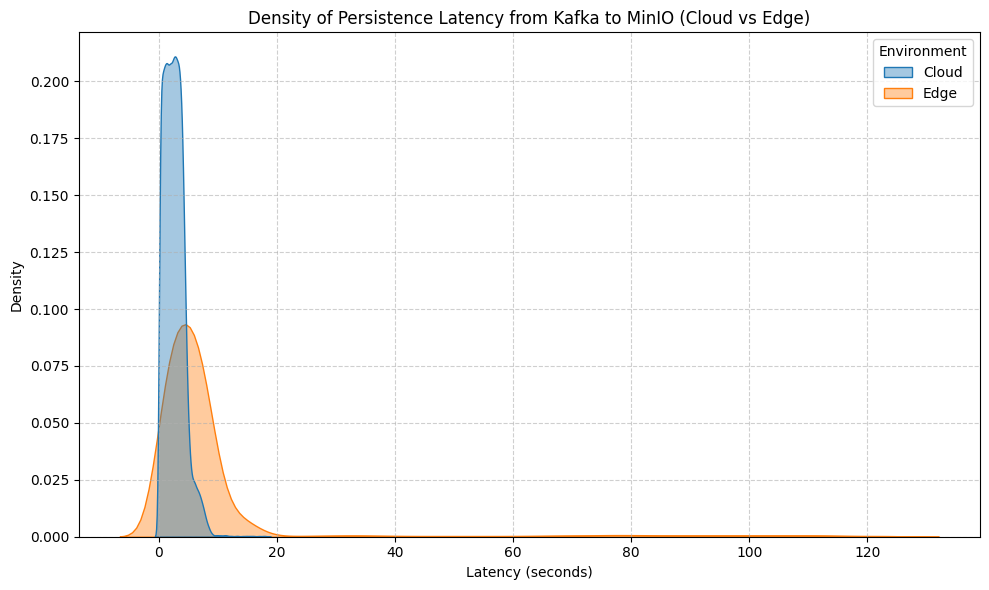

In [13]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Density of Persistence Latency from Kafka to MinIO (Cloud vs Edge)", save_path="./latency-spark-density.png")

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


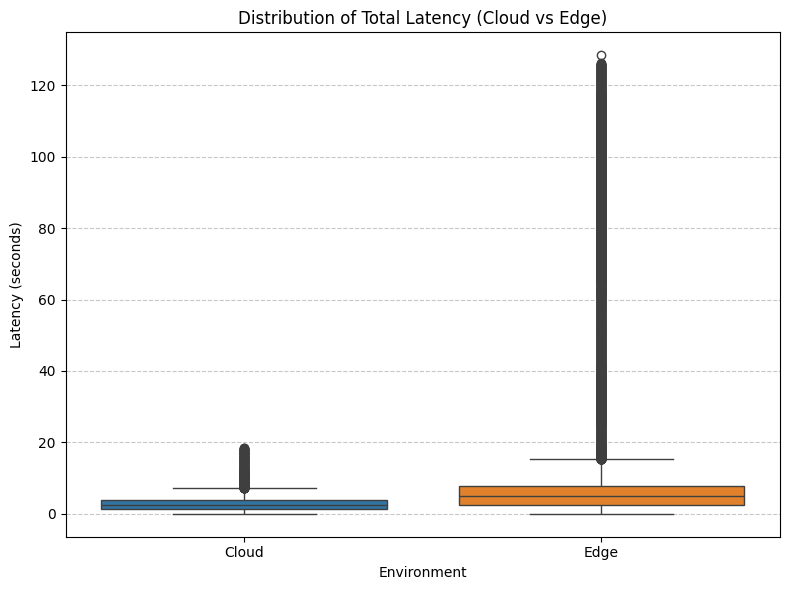

In [14]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="total_latency", title="Distribution of Total Latency (Cloud vs Edge)", save_path="./latency-total-boxplot.png")

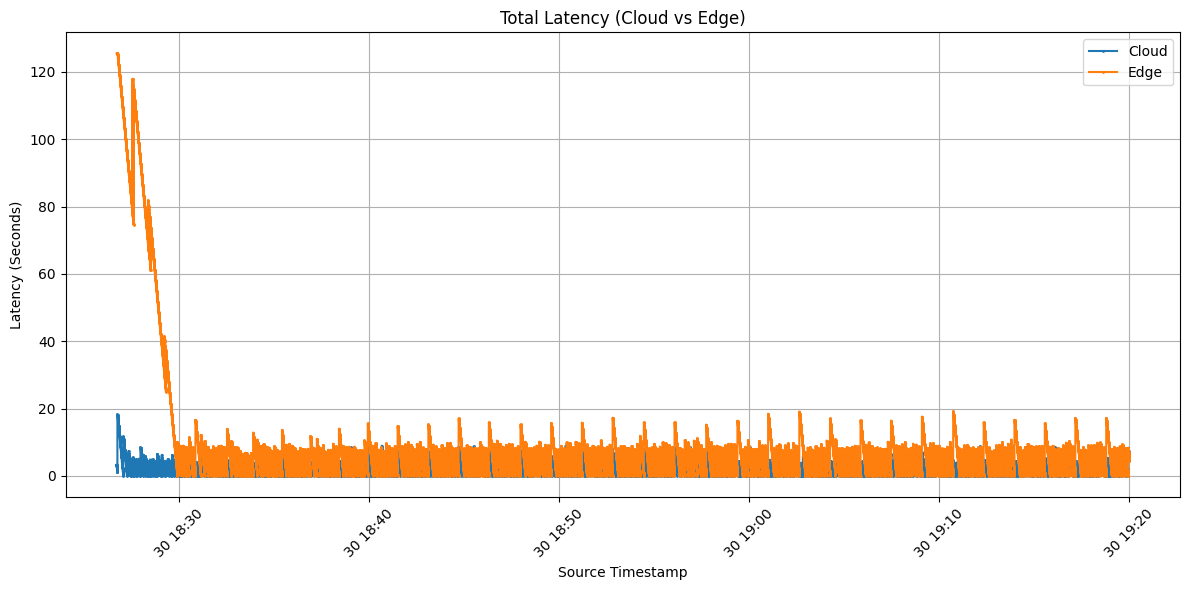

In [15]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Total Latency (Cloud vs Edge)', linestyle="solid", save_path="./latency-spark-scatterplot.png")

📊 Statistics:
                 mean  median        std
Environment                             
Cloud        2.584331   2.427   1.775343
Edge         8.897339   5.099  17.553246


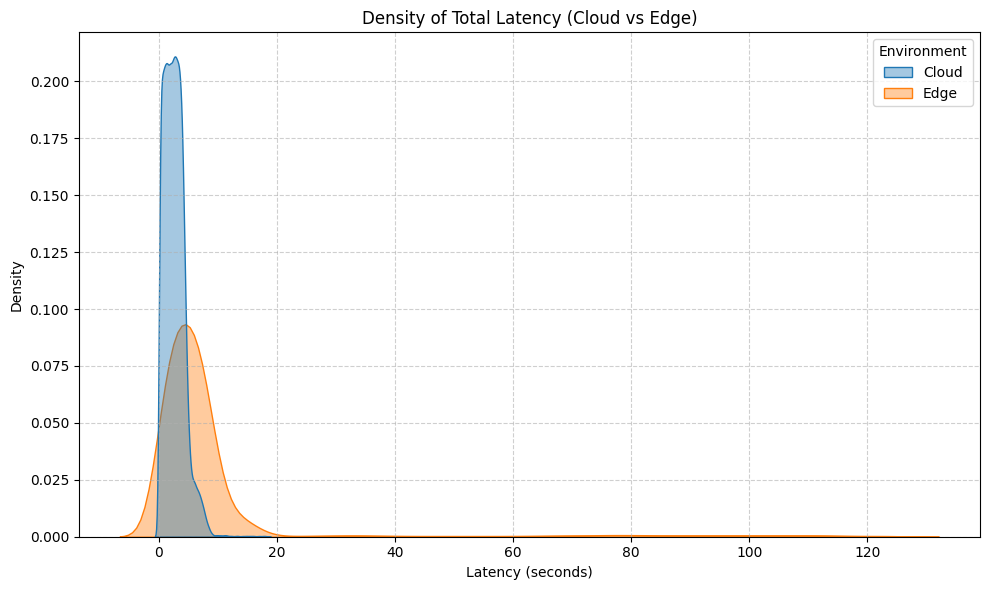

In [16]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Density of Total Latency (Cloud vs Edge)", save_path="./latency-spark-density.png")